# Customer Segmentation Pipeline (RFM + KMeans)

This notebook implements a production-quality RFM-based customer segmentation pipeline using the transactional `online_retail.csv` dataset.

Sections: 1) Setup  2) Load & Clean  3) RFM Feature Engineering  4) EDA  5) Transformations  6) Clustering & Evaluation  7) Profiling & Visualization 

## Setup
Install requirements (recommended to run in a dedicated virtual environment or codespace).
Run in a terminal: `pip install -r requirements.txt`

This notebook imports helper modules from the `customer_segmentation` package in the repository. If you copy this notebook to a new codespace, ensure the repository files are present.

In [ ]:
# Import libraries and set paths
import os
import sys
from pathlib import Path

# Add repository root to sys.path
repo_root = str(Path().resolve().parent)
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
from customer_segmentation.load_and_clean import load_data, clean_data
from customer_segmentation.rfm import compute_rfm
from customer_segmentation.transform import transform_rfm
from customer_segmentation.modeling import find_clusters, plot_selection, fit_kmeans
from customer_segmentation.profiling import assign_and_profile
from customer_segmentation.visualize import pca_plot

# Define paths
DATA_PATH = "/workspaces/codespaces-jupyter/Ds_project_Customer_Segmentation/Dataset/online_retail.csv"
OUT_DIR = "outputs_notebook"
os.makedirs(OUT_DIR, exist_ok=True)

# Load data
df = load_data(DATA_PATH)
print(f"Raw rows: {len(df):,}")
df.head()

Raw rows: 541,909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
# Compute RFM
df_clean = clean_data(df)
rfm, snapshot = compute_rfm(df_clean)
print("Snapshot date:", snapshot)
print("Customers:", len(rfm))
rfm.head()

Snapshot date: 2011-12-10 12:50:00
Customers: 4338


,CustomerID,RecencyDays,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


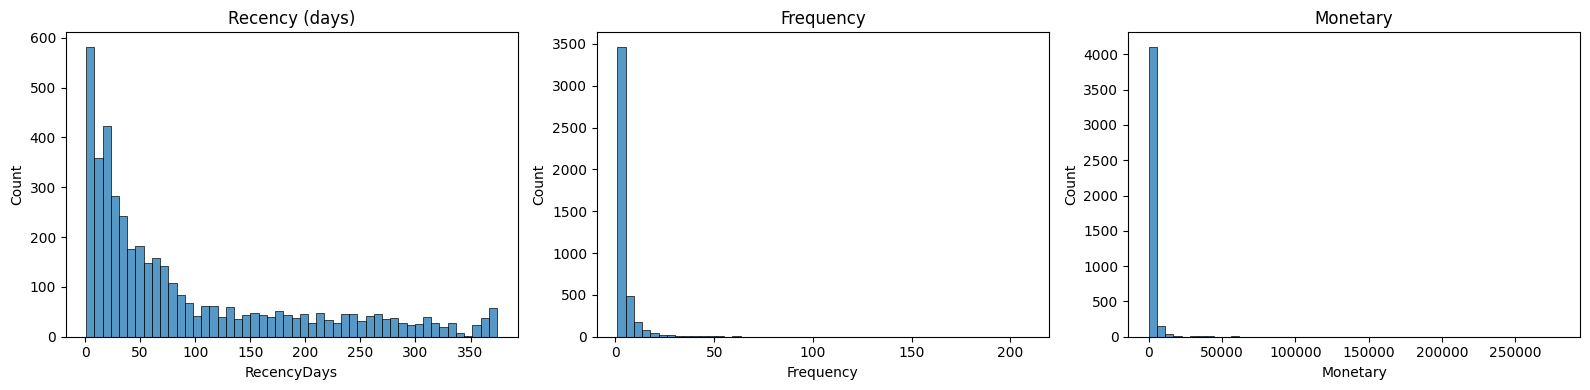

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# EDA: distributions
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.histplot(rfm['RecencyDays'], bins=50, ax=axes[0])
axes[0].set_title('Recency (days)')
sns.histplot(rfm['Frequency'], bins=50, ax=axes[1])
axes[1].set_title('Frequency')
sns.histplot(rfm['Monetary'], bins=50, ax=axes[2])
axes[2].set_title('Monetary')
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, 'eda_distributions.png'))
plt.show()

In [15]:
# Transform and scale
X_scaled, scaler, features = transform_rfm(rfm)
print('Features used:', features)
print('Scaled shape:', X_scaled.shape)

Features used: ['Recency_log', 'Frequency_log', 'Monetary_log']
Scaled shape: (4338, 3)


In [16]:
# Model selection (Elbow + Silhouette)
ks, inertias, silhouettes = find_clusters(X_scaled, k_min=2, k_max=10)
plot_selection(ks, inertias, silhouettes, outpath=os.path.join(OUT_DIR, 'selection_plot.png'))
# Display numeric table of selection metrics
pd.DataFrame({
    'k': ks,
    'inertia': inertias,
    'silhouette': silhouettes
})

,k,inertia,silhouette
0,2,6481.225323,0.432940
1,3,4867.846645,0.336510
2,4,3938.509954,0.337134
3,5,3295.976329,0.316097
4,6,2855.011247,0.313329
5,7,2548.914324,0.309975
6,8,2336.777508,0.300782
7,9,2155.648193,0.281653
8,10,1999.903270,0.278665


In [17]:
# Choose best k (by silhouette)
best_k = ks[int(np.nanargmax(silhouettes))]
print('Chosen k by silhouette:', best_k)
km, labels = fit_kmeans(X_scaled, best_k)
rfm_labeled, profile = assign_and_profile(rfm, labels)
rfm_labeled.to_csv(os.path.join(OUT_DIR, 'rfm_customers.csv'), index=False)
profile.to_csv(os.path.join(OUT_DIR, 'rfm_profile.csv'), index=False)
profile

Chosen k by silhouette: 2


,Cluster,Count,Recency_mean,Frequency_mean,Monetary_mean,Recency_median,Frequency_median,Monetary_median
1,1,1667,25.883623,8.440312,4548.258417,16.0,6.0,2064.95
0,0,2671,134.135155,1.670535,497.739095,96.0,1.0,363.88


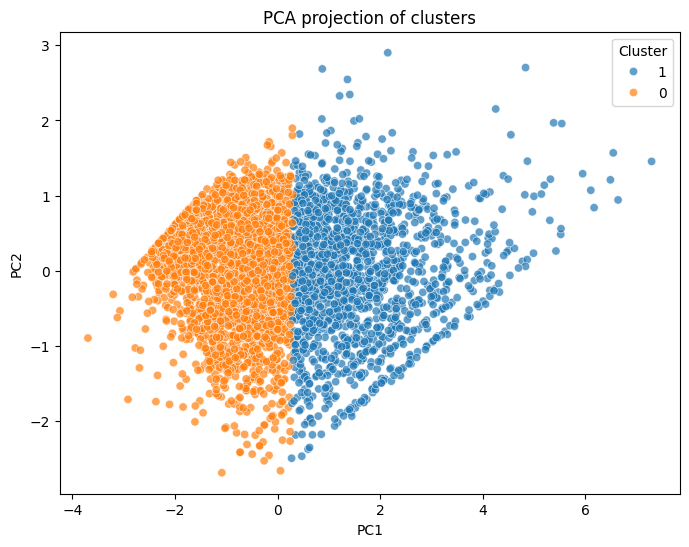

In [19]:
# PCA visualization
pca_plot(X_scaled, labels, outpath=os.path.join(OUT_DIR, 'pca_clusters.png'))
from IPython.display import Image, display
display(Image(os.path.join(OUT_DIR, 'pca_clusters.png')))


In [ ]:
# Adjust path based on path location. 
df_profile = pd.read_csv("/workspaces/codespaces-jupyter/outputs/rfm_profile.csv")


In [ ]:
#rfm profiles
df_profile

,Cluster,Count,Recency_mean,Frequency_mean,Monetary_mean,Recency_median,Frequency_median,Monetary_median
0,1,1667,25.883623,8.440312,4548.258417,16.0,6.0,2064.95
1,0,2671,134.135155,1.670535,497.739095,96.0,1.0,363.88
